In [1]:
import sys
import torch
import dlib
import csv
import utils
import torch.nn.functional as F

model_name = "model/40_Siamese1.pth"
image_size = 160

In [2]:
def inference(model, test_image_path, gt_path, neg_path):
    at_least_one_missing = False
    img = utils.read_pil_image(test_image_path)
   
    cv_image = utils.read_image(test_image_path)
    firstline = True
    #############################################
    # Go through 60 ROIs and check similarity with
    # positive and negative crop
    #############################################
    with open('rois.csv', newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        spamreader = csv.reader(csvfile, delimiter=',')
        for row in spamreader:
            if firstline: 
                firstline = False
                continue    
            box = dlib.rectangle(int(row[1]), int(row[2]), int(row[3]), int(row[4]))
            test_crop = img.crop((box.left(),box.top(),box.right(), box.bottom()))
            test_crop = utils.process_image(test_crop)

            model.to("cuda")
            model.eval()
            
            #################################################################################
            # we could use various positive and negative samples to check similarity,
            # instead of just using 1 sample
            #################################################################################
            pos_crop, neg_crop = utils.get_random_positive_and_negative_sample(gt_path, neg_path,
                    component_name = row[0])

            out = model(test_crop.cuda(),pos_crop.cuda())
            euclidean_distance_with_pos = F.pairwise_distance(out[0], out[1])
            
            out = model(test_crop.cuda(),neg_crop.cuda())
            euclidean_distance_with_neg = F.pairwise_distance(out[0], out[1])
           
            ##########################################################################
            # If Dissimilarity with negative class is less than that with positive class
            # We conclude that component is missing
            ##########################################################################
            if euclidean_distance_with_neg.item() < euclidean_distance_with_pos.item():
                print("Component ", row[0], " Missing")
                at_least_one_missing = True
                utils.draw_boxes(cv_image, [box])
    utils.display_image(cv_image)           
    return at_least_one_missing


Component  29  Missing
Component  30  Missing


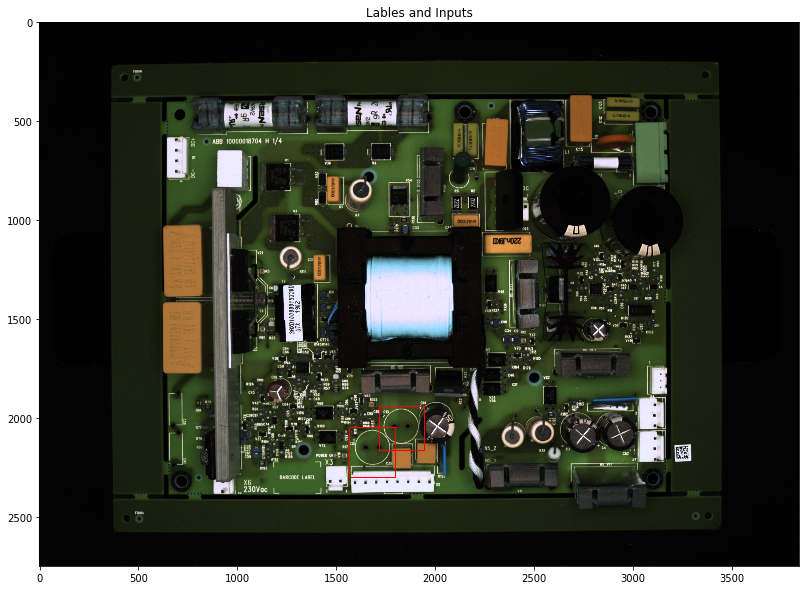

In [3]:
model = utils.MobileNetV2(n_class=5, input_size=image_size)
model.load_state_dict(torch.load(model_name))

gt_path = "./60_comps"
neg_path = "./negative_separated"
Missing = inference(model, "24.24.jpg", gt_path, neg_path)
if not Missing:
    print("No Errors")

Component  14  Missing
Component  35  Missing


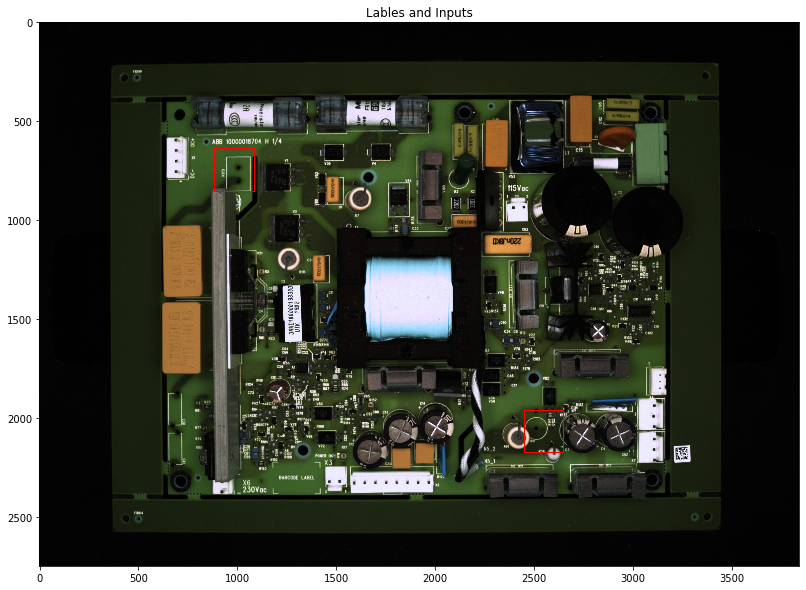

In [5]:
Missing = inference(model, "30.30.jpg", gt_path, neg_path)
if not Missing:
    print("No Errors")